In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras import backend as K
#from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle


import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

#To run project notebooks in subfolders as from root folder
import sys
sys.path.append('../../')

###Import self-written library
from featexlib import Debug as dbug
from featexlib import *

#for autorealoading the submodules
%load_ext autoreload
%autoreload 2

x_load.shape = (293, 256, 768, 3) , y_load.shape = (293, 256, 768, 11)
Amount of classes: 11


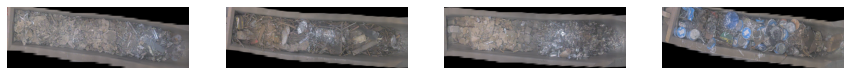

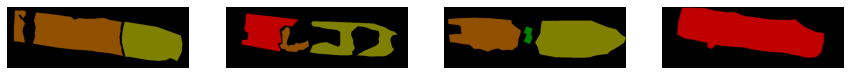

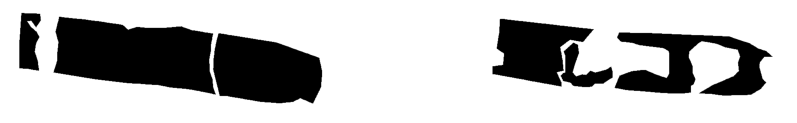

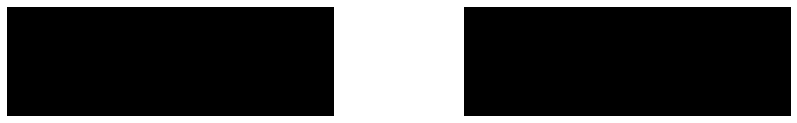

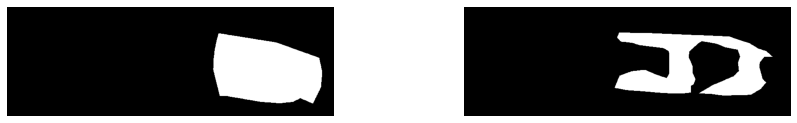

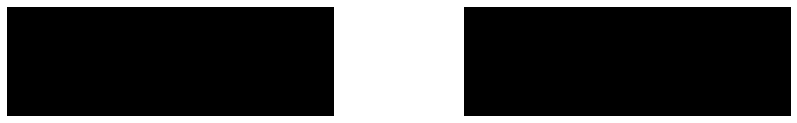

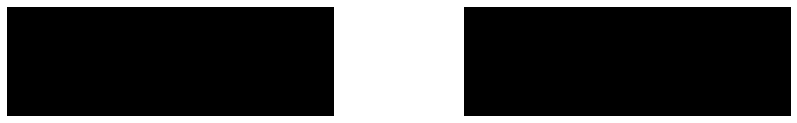

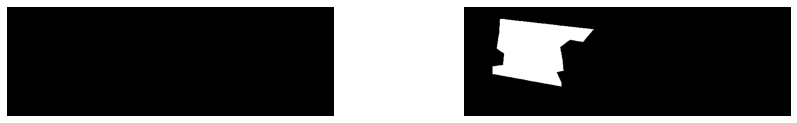

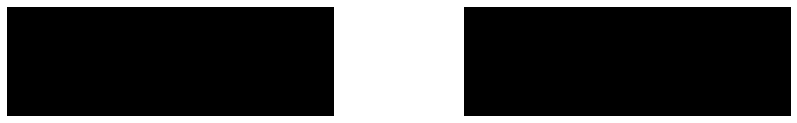

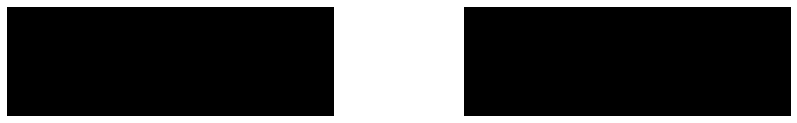

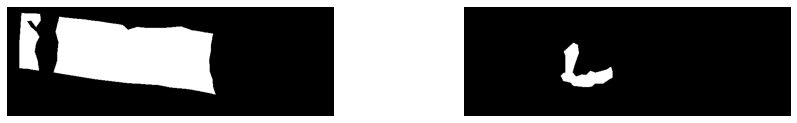

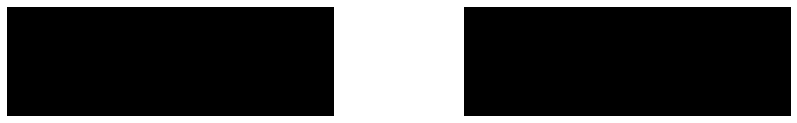

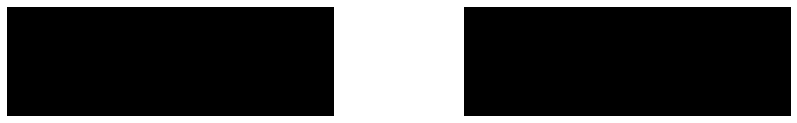

In [2]:
###ACTIVE CELL####
###Load data
###Testing that data has been saved and can be loaded

x_load, y_load, y_load_raw = Image_generator.load_data(save_dir = "../../Data/scrapid/training_data/", name="scrapid_11c_768x256_293_1")

print("===================================")

#Show some result images
print('x_load.shape =',x_load.shape,',', 'y_load.shape =',y_load.shape)
print('Amount of classes:',  y_load.shape[-1])
dbug.show_images_list(x_load[:4,...], col_number = 4)
dbug.show_images_list(y_load_raw[:4,...], col_number = 4)
for c in range(y_load.shape[-1]):
    dbug.show_images_list(y_load[:2,...,c], col_number = 2) 
    


In [3]:
###ACTIVE CELL####
###Split data to test and train
n_offset = 0
n_train = 250
n_test = 43
pic_h = x_load.shape[1]
pic_w = x_load.shape[2]
pic_ch = x_load.shape[3] if len(x_load.shape)>3 else 1
num_classes = y_load.shape[-1]

###Get X train and test
x_train, x_test = x_load[n_offset:n_offset+n_train], x_load[n_offset+n_train:n_offset+n_train+n_test]
y_train, y_test = y_load[n_offset:n_offset+n_train], y_load[n_offset+n_train:n_offset+n_train+n_test]
y_train_raw, y_test_raw = y_load_raw[n_offset:n_offset+n_train], y_load_raw[n_offset+n_train:n_offset+n_train+n_test]

print("===============Data is ready====================")
print("Shape X,Y for train:",x_train.shape,y_train.shape)
print("Shape X,Y for test: ",x_test.shape,y_test.shape)

###Clean memory
del x_load, y_load, y_load_raw

===============Data is ready====================
Shape X,Y for train: (250, 256, 768, 3) (250, 256, 768, 11)
Shape X,Y for test:  (43, 256, 768, 3) (43, 256, 768, 11)


In [4]:
###ACTIVE CELL####
###Reshape and then rescale dataset
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1))
x_test_sc  = scaler.transform(x_test.reshape(x_test.shape[0],-1))

if y_train.max() > 1:
    y_train_sc = y_train/255
    y_test_sc  = y_test/255
else:
    y_train_sc = y_train
    y_test_sc  = y_test
        
print(x_train_sc.shape, y_train_sc.shape, x_test_sc.shape, y_test_sc.shape)

(250, 589824) (250, 256, 768, 11) (43, 589824) (43, 256, 768, 11)


In [5]:
###ACTIVE CELL####
x_test_sc.mean()

-0.051652662612768546

In [10]:
###ACTIVE CELL#####
###Calculate dataset balancing

balance_table = np.array([np.mean(np.argmax(y_train, axis=-1) == c) for c in range(y_train.shape[-1])])
print('Class balance:')
print(balance_table)

def get_balanced_weight(inp, norm=False):
    norm_inp =  inp/inp.sum()
    
    num_classes = len(inp)
    
    ideal = 1/num_classes
    
    k_arr = np.array([(ideal/i) if i != 0 else 0 for i in norm_inp] )
    
    if norm:
        return k_arr/k_arr.sum()
    else:
        return k_arr

################################
###Enter custom balance table if you want:
#e.g. 
balance_table = np.array([4, 0, 2, 1.8,
 1, 1, 1, 1,
 1, 1, 1])

class_weights = get_balanced_weight(balance_table)
print('Weight table:')
print(class_weights)


Class balance:
[5.84015259e-01 0.00000000e+00 1.32155009e-01 1.25003276e-01
 8.33699137e-02 4.44337362e-02 2.29309082e-04 1.62086995e-03
 2.40502116e-02 3.43922933e-03 1.68318685e-03]
Weight table:
[0.33636364 0.         0.67272727 0.74747475 1.34545455 1.34545455
 1.34545455 1.34545455 1.34545455 1.34545455 1.34545455]


In [11]:
###ACTIVE CELL####
###Export scaler
pickle.dump(scaler, open('../../models/scalers/scrapid_11c_850x256_293_1_unet_scaler_v1.pkl','wb'))

###Load scaler
#scaler = pickle.load(open('models/scalers/scrapid_7c_850x256_10_1_unet_scaler_v1.pkl','rb'))

In [ ]:
###Load scaler
##NOT USED
scaler = pickle.load(open('models/scalers/scrapid_11c_850x256_293_1_unet_scaler_v1.pkl','rb'))
x_test_sc  = scaler.transform(x_test.reshape(x_test.shape[0],-1))
x_test_sc.mean()

In [12]:
###ACTIVE CELL####
###Prepare for training: check labels dimension (-1), change X to float32 instead of float64
ys = y_train_sc.astype('float32').reshape(-1,pic_h,pic_w,num_classes)
xs = x_train_sc.astype('float32').reshape(-1,pic_h,pic_w,pic_ch)
#ys_one_hot = tf.one_hot(ys, num_classes) ###not used

ys_test = y_test_sc.reshape(-1,pic_h,pic_w,num_classes)
xs_test = x_test_sc.astype('float32').reshape(-1,pic_h,pic_w,pic_ch)

###Clear memory
#del x_train, y_train, y_test, x_test
print(xs.shape, ys.shape, xs_test.shape, ys_test.shape)

(250, 256, 768, 3) (250, 256, 768, 11) (43, 256, 768, 3) (43, 256, 768, 11)


In [10]:
###NOT USED
###SHUFFLE THE DATA

#Help function
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

#xs,ys = unison_shuffled_copies(xs,ys)

In [13]:
###ACTIVE CELL####
#Model
#Prepare model transfer-learned VGG16

K.clear_session()
def unet(pretrained_weights = None,input_size = (256,768,3), full_train=False):
    VGG16_weight = "../../models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    VGG16 = tf.keras.applications.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_size)
    last_layer = VGG16.output
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = full_train
            
    model_ = tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2, 2), padding='same')(last_layer)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)    
    
    concat_1 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block5_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1), padding='same')(concat_1)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_2 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block4_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1), padding='same')(concat_2)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(512,(3,3),strides=(2, 2), padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_3 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block3_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1), padding='same')(concat_3)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_4 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block2_conv2").output])
    
    model_ = tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1), padding='same')(concat_4)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_5 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block1_conv2").output])
    
    model_ = tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1), padding='same')(concat_5)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1), padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2D(11,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    #model_ = tf.keras.layers.Softmax()(model_)

    model_ = tf.keras.Model(VGG16.input,model_)
    
    model_.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4), loss=weightedLoss(tf.keras.losses.CategoricalHinge(), class_weights), metrics=[Mean_IOU_tensorflow_2])
    #model_.compile(optimizer='sgd', loss=weightedLoss(tf.keras.losses.MeanSquaredError(), class_weights), metrics=[Mean_IOU_tensorflow_2])
    #model_.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError(), metrics=[Mean_IOU_tensorflow_2])
    
    #model_.compile(optimizer ='sgd', loss = 'categorical_hinge', metrics = [Mean_IOU_tensorflow_2])
    #model_.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'categorical_hinge', metrics = ['accuracy'])
    #model_.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    if(pretrained_weights):
        model_.load_weights(pretrained_weights)
    
    return model_

def Mean_IOU_tensorflow_2(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    true_pixels = K.argmax(y_true, axis=-1)
    pred_pixels = K.argmax(y_pred, axis=-1)
    void_labels = K.equal(K.sum(y_true, axis=-1), 0)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(true_pixels, i) & ~void_labels
        pred_labels = K.equal(pred_pixels, i) & ~void_labels
        inter = tf.cast(true_labels & pred_labels, tf.int32)
        union = tf.cast(true_labels | pred_labels, tf.int32)
        legal_batches = K.sum(tf.cast(true_labels, tf.int32), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(ious[legal_batches]))
    iou = tf.stack(iou)
    legal_labels = ~tf.math.is_nan(iou)
    iou = iou[legal_labels]
    return K.mean(iou)


def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first

        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.cast(K.argmax(true, axis=axis), tf.int32) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [14]:
####ACTIVE CELL#####
#New training
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 768, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 768, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
####ACTIVE CELL#####
###Continue model training
model = unet()
model.load_weights('../../models/scrapid_11c_768x256_293_1_unet_acc03627')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 768, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 768, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [16]:
####ACTIVE CELL#####
#Initialise checkpointer
checkpointer = tf.keras.callbacks.ModelCheckpoint('../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5', verbose=1,mode='auto', monitor='loss',save_best_only=True)

def shuffle_x_y(inp_x, inp_y):   
    combo = np.c_[inp_x.reshape(len(inp_x), -1), inp_y.reshape(len(inp_y), -1)]
    np.random.shuffle(combo)
    x_out = combo[:, :inp_x.size//len(inp_x)].reshape(inp_x.shape)
    y_out = combo[:, inp_x.size//len(inp_x):].reshape(inp_y.shape)
    return x_out, y_out

#Data generator
def GenerateInputs(X,y, shuffle=True):
    
    while True:
        for i in range(len(X)):
            X_input = X[i].reshape(-1,pic_h,pic_w,pic_ch)
            y_input = y[i].reshape(-1,pic_h,pic_w,num_classes)
            yield (X_input,y_input)
        

In [17]:
####ACTIVE CELL#####
model.fit(GenerateInputs(xs,ys, shuffle=False), batch_size=1, epochs=250, steps_per_epoch = 8, shuffle=True, callbacks=[checkpointer])

Epoch 1/250
8/8 [==============================] - ETA: 0s - loss: 1.6677 - Mean_IOU_tensorflow_2: 0.1132
Epoch 00001: loss improved from inf to 1.66765, saving model to ../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5
8/8 [==============================] - 66s 8s/step - loss: 1.6677 - Mean_IOU_tensorflow_2: 0.1132
Epoch 2/250
8/8 [==============================] - ETA: 0s - loss: 1.0955 - Mean_IOU_tensorflow_2: 0.2092
Epoch 00002: loss improved from 1.66765 to 1.09550, saving model to ../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5
8/8 [==============================] - 64s 8s/step - loss: 1.0955 - Mean_IOU_tensorflow_2: 0.2092
Epoch 3/250
8/8 [==============================] - ETA: 0s - loss: 1.0123 - Mean_IOU_tensorflow_2: 0.2663
Epoch 00003: loss improved from 1.09550 to 1.01226, saving model to ../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5
8/8 [==============================] - 70s 9s/step - loss: 1.0123 - Mean_IOU_tensorflow_2: 0.2663
Epoch 4/250
8/8 [==================

Epoch 29/250
8/8 [==============================] - ETA: 0s - loss: 0.3934 - Mean_IOU_tensorflow_2: 0.4074
Epoch 00029: loss improved from 0.39865 to 0.39342, saving model to ../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5
8/8 [==============================] - 62s 8s/step - loss: 0.3934 - Mean_IOU_tensorflow_2: 0.4074
Epoch 30/250
8/8 [==============================] - ETA: 0s - loss: 0.4424 - Mean_IOU_tensorflow_2: 0.4584
Epoch 00030: loss did not improve from 0.39342
8/8 [==============================] - 61s 8s/step - loss: 0.4424 - Mean_IOU_tensorflow_2: 0.4584
Epoch 31/250
8/8 [==============================] - ETA: 0s - loss: 0.3467 - Mean_IOU_tensorflow_2: 0.5096
Epoch 00031: loss improved from 0.39342 to 0.34671, saving model to ../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5
8/8 [==============================] - 69s 9s/step - loss: 0.3467 - Mean_IOU_tensorflow_2: 0.5096
Epoch 32/250
8/8 [==============================] - ETA: 0s - loss: 0.4869 - Mean_IOU_tensorflow_2: 

Epoch 61/250
8/8 [==============================] - ETA: 0s - loss: 0.4163 - Mean_IOU_tensorflow_2: 0.4301
Epoch 00061: loss did not improve from 0.34037
8/8 [==============================] - 62s 8s/step - loss: 0.4163 - Mean_IOU_tensorflow_2: 0.4301
Epoch 62/250
8/8 [==============================] - ETA: 0s - loss: 0.3173 - Mean_IOU_tensorflow_2: 0.5095
Epoch 00062: loss improved from 0.34037 to 0.31732, saving model to ../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5
8/8 [==============================] - 62s 8s/step - loss: 0.3173 - Mean_IOU_tensorflow_2: 0.5095
Epoch 63/250
8/8 [==============================] - ETA: 0s - loss: 0.4071 - Mean_IOU_tensorflow_2: 0.4417
Epoch 00063: loss did not improve from 0.31732
8/8 [==============================] - 60s 7s/step - loss: 0.4071 - Mean_IOU_tensorflow_2: 0.4417
Epoch 64/250
8/8 [==============================] - ETA: 0s - loss: 0.3649 - Mean_IOU_tensorflow_2: 0.5082
Epoch 00064: loss did not improve from 0.31732
8/8 [=============

Epoch 93/250
8/8 [==============================] - ETA: 0s - loss: 0.3267 - Mean_IOU_tensorflow_2: 0.4882
Epoch 00093: loss did not improve from 0.31142
8/8 [==============================] - 72s 9s/step - loss: 0.3267 - Mean_IOU_tensorflow_2: 0.4882
Epoch 94/250
8/8 [==============================] - ETA: 0s - loss: 0.3788 - Mean_IOU_tensorflow_2: 0.4844
Epoch 00094: loss did not improve from 0.31142
8/8 [==============================] - 70s 9s/step - loss: 0.3788 - Mean_IOU_tensorflow_2: 0.4844
Epoch 95/250
8/8 [==============================] - ETA: 0s - loss: 0.3550 - Mean_IOU_tensorflow_2: 0.5239
Epoch 00095: loss did not improve from 0.31142
8/8 [==============================] - 70s 9s/step - loss: 0.3550 - Mean_IOU_tensorflow_2: 0.5239
Epoch 96/250
8/8 [==============================] - ETA: 0s - loss: 0.3216 - Mean_IOU_tensorflow_2: 0.4147
Epoch 00096: loss did not improve from 0.31142
8/8 [==============================] - 70s 9s/step - loss: 0.3216 - Mean_IOU_tensorflow_2:

Epoch 125/250
8/8 [==============================] - ETA: 0s - loss: 0.3478 - Mean_IOU_tensorflow_2: 0.5128
Epoch 00125: loss did not improve from 0.29907
8/8 [==============================] - 63s 8s/step - loss: 0.3478 - Mean_IOU_tensorflow_2: 0.5128
Epoch 126/250
8/8 [==============================] - ETA: 0s - loss: 0.3840 - Mean_IOU_tensorflow_2: 0.4806
Epoch 00126: loss did not improve from 0.29907
8/8 [==============================] - 66s 8s/step - loss: 0.3840 - Mean_IOU_tensorflow_2: 0.4806
Epoch 127/250
8/8 [==============================] - ETA: 0s - loss: 0.2820 - Mean_IOU_tensorflow_2: 0.4618
Epoch 00127: loss improved from 0.29907 to 0.28204, saving model to ../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5
8/8 [==============================] - 64s 8s/step - loss: 0.2820 - Mean_IOU_tensorflow_2: 0.4618
Epoch 128/250
8/8 [==============================] - ETA: 0s - loss: 0.3216 - Mean_IOU_tensorflow_2: 0.4491
Epoch 00128: loss did not improve from 0.28204
8/8 [=========

8/8 [==============================] - ETA: 0s - loss: 0.3894 - Mean_IOU_tensorflow_2: 0.4831
Epoch 00157: loss did not improve from 0.28204
8/8 [==============================] - 74s 9s/step - loss: 0.3894 - Mean_IOU_tensorflow_2: 0.4831
Epoch 158/250
8/8 [==============================] - ETA: 0s - loss: 0.2981 - Mean_IOU_tensorflow_2: 0.4792
Epoch 00158: loss did not improve from 0.28204
8/8 [==============================] - 72s 9s/step - loss: 0.2981 - Mean_IOU_tensorflow_2: 0.4792
Epoch 159/250
8/8 [==============================] - ETA: 0s - loss: 0.3129 - Mean_IOU_tensorflow_2: 0.4469
Epoch 00159: loss did not improve from 0.28204
8/8 [==============================] - 75s 9s/step - loss: 0.3129 - Mean_IOU_tensorflow_2: 0.4469
Epoch 160/250
8/8 [==============================] - ETA: 0s - loss: 0.3098 - Mean_IOU_tensorflow_2: 0.4611
Epoch 00160: loss did not improve from 0.28204
8/8 [==============================] - 73s 9s/step - loss: 0.3098 - Mean_IOU_tensorflow_2: 0.4611
Ep

8/8 [==============================] - ETA: 0s - loss: 0.3126 - Mean_IOU_tensorflow_2: 0.5218 
Epoch 00189: loss did not improve from 0.28204
8/8 [==============================] - 80s 10s/step - loss: 0.3126 - Mean_IOU_tensorflow_2: 0.5218
Epoch 190/250
8/8 [==============================] - ETA: 0s - loss: 0.2936 - Mean_IOU_tensorflow_2: 0.4304
Epoch 00190: loss did not improve from 0.28204
8/8 [==============================] - 79s 10s/step - loss: 0.2936 - Mean_IOU_tensorflow_2: 0.4304
Epoch 191/250
8/8 [==============================] - ETA: 0s - loss: 0.3147 - Mean_IOU_tensorflow_2: 0.4434
Epoch 00191: loss did not improve from 0.28204
8/8 [==============================] - 76s 9s/step - loss: 0.3147 - Mean_IOU_tensorflow_2: 0.4434
Epoch 192/250
8/8 [==============================] - ETA: 0s - loss: 0.2798 - Mean_IOU_tensorflow_2: 0.5660
Epoch 00192: loss improved from 0.28204 to 0.27982, saving model to ../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5
8/8 [====================

8/8 [==============================] - ETA: 0s - loss: 0.2846 - Mean_IOU_tensorflow_2: 0.4198
Epoch 00221: loss did not improve from 0.27982
8/8 [==============================] - 71s 9s/step - loss: 0.2846 - Mean_IOU_tensorflow_2: 0.4198
Epoch 222/250
8/8 [==============================] - ETA: 0s - loss: 0.3077 - Mean_IOU_tensorflow_2: 0.4466
Epoch 00222: loss did not improve from 0.27982
8/8 [==============================] - 74s 9s/step - loss: 0.3077 - Mean_IOU_tensorflow_2: 0.4466
Epoch 223/250
8/8 [==============================] - ETA: 0s - loss: 0.2784 - Mean_IOU_tensorflow_2: 0.5204
Epoch 00223: loss improved from 0.27982 to 0.27844, saving model to ../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5
8/8 [==============================] - 80s 10s/step - loss: 0.2784 - Mean_IOU_tensorflow_2: 0.5204
Epoch 224/250
8/8 [==============================] - ETA: 0s - loss: 0.2994 - Mean_IOU_tensorflow_2: 0.5045
Epoch 00224: loss did not improve from 0.27844
8/8 [======================

In [25]:
###NOT USED##########
#fit model for big data
#model.fit_generator(GenerateInputs(xs,ys), epochs=31, verbose=1,callbacks=[checkpointer],
#                     steps_per_epoch=8,shuffle=True)

In [18]:
###Save model after training
model.save_weights('../../models/scrapid_11c_768x256_293_1_unet_acc05188')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 768, 64  1792        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 768, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

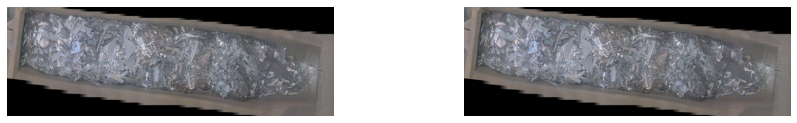

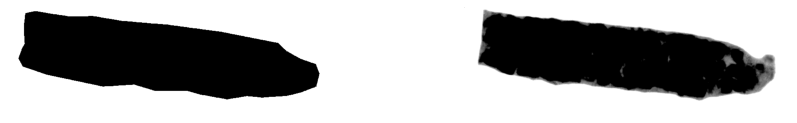

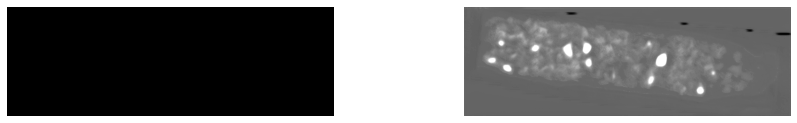

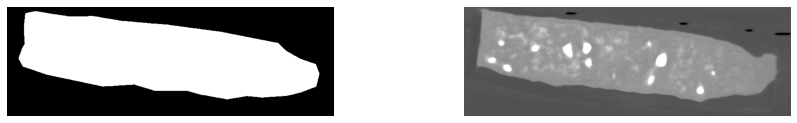

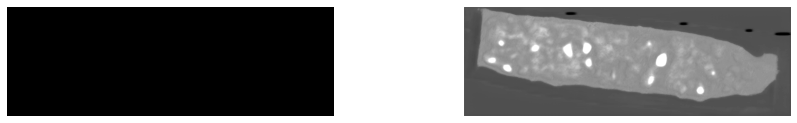

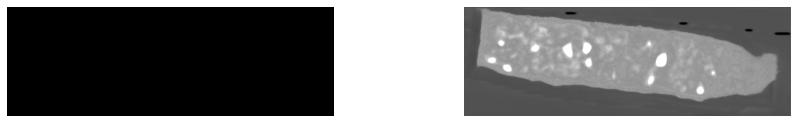

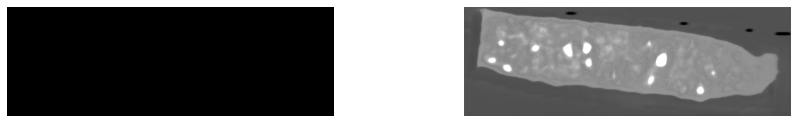

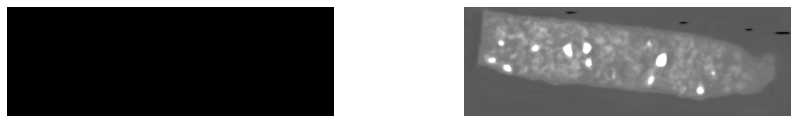

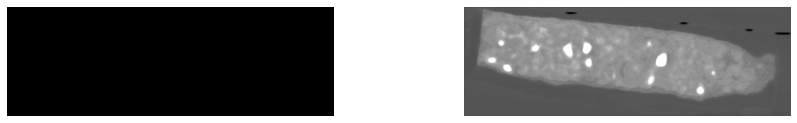

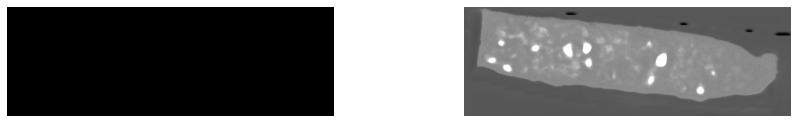

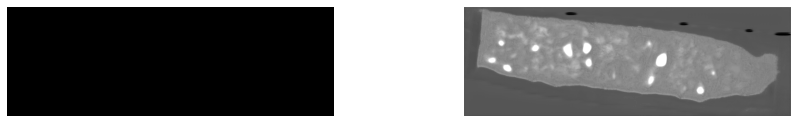

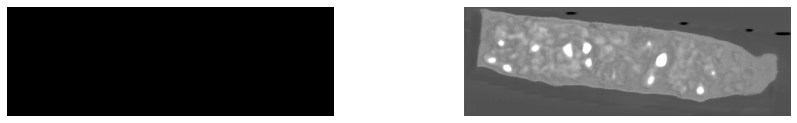

In [20]:
def show_predict(x,x_orig,y_orig, number):
    y_pred = model(x[number].reshape(-1,pic_h,pic_w,pic_ch)).numpy()
    y_pred = (np.clip(((y_pred - y_pred.mean() + y_pred.std())/y_pred.std())*127, 0,255)).astype('int16')
    dbug.show_images_list([x_orig[number],x_orig[number]], col_number = 2)
    for c in range(y_orig.shape[-1]):
        dbug.show_images_list([y_orig[number,...,c].reshape(pic_h,pic_w,1), y_pred[...,c].reshape(pic_h,pic_w,1)], col_number = 2) 


numm = 0
show_predict(xs_test,x_test,y_test, numm)

In [21]:
####ACTIVE CELL#####
#Helpful functions for showing result

#List of codes, should be the same as in training
list_of_codes_colors = [
    0, #Black
    64, #Dark red
    32896, #Yellow
    8388608, #Blue
    32768, #Green
    192, #Red
    8388736, #Violet
    4194448, ##????
    20624, ##????
    52443, ##????
    10911041, ##????
]
#Help function to get RGB codes from DEC
def get_rgb_from_codes(inp):
    return np.array([[i//65536,(i - 65536*(i//65536))//256, i - 65536*(i//65536) - 256*((i - 65536*(i//65536))//256)] for i in inp]).astype(np.uint8)

list_of_colors = get_rgb_from_codes(list_of_codes_colors)


def show_predict_multi(x,x_orig,y_orig, number):
    
    y_pred = model(x[number].reshape(-1,pic_h,pic_w,pic_ch)).numpy()
    
    res_r = np.argmax(y_pred, axis=3)
    res_g = np.copy(res_r)
    res_b = np.copy(res_r)



    for c in range(y_pred.shape[-1]):
        res_r[res_r == c] =  list_of_colors[c,0]
        res_g[res_g == c] =  list_of_colors[c,1]
        res_b[res_b == c] =  list_of_colors[c,2]

    res = np.concatenate([res_r[...,None],res_g[...,None],res_b[...,None]], axis=3)
    
    
    for c in range(res.shape[0]):
        dbug.show_images_list([x_orig[number][c,...],res[c,...],y_orig[number][c,...]],col_number = 3)
        #dbug.show_images_list(res[c,...],col_number = 3)
        #dbug.show_images_list(y_orig[number][c,...],col_number = 3)

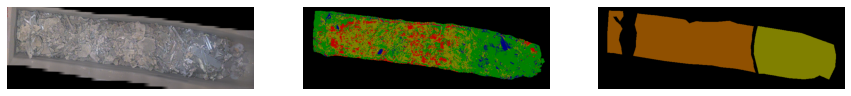

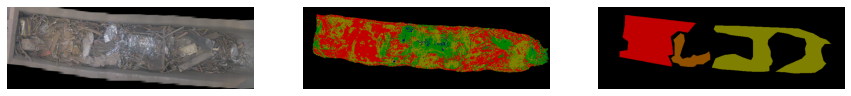

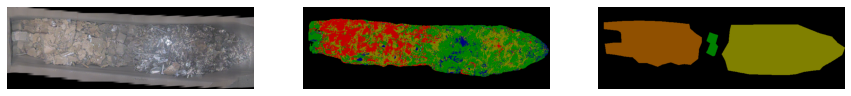

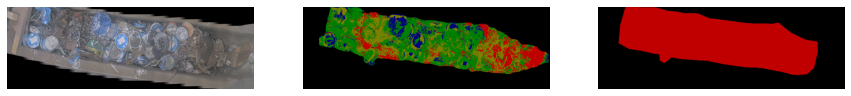

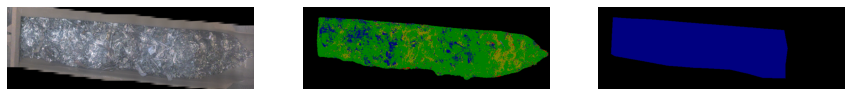

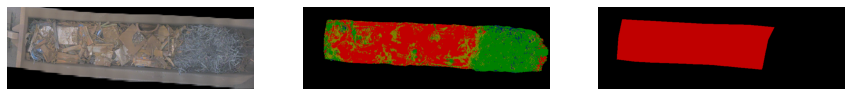

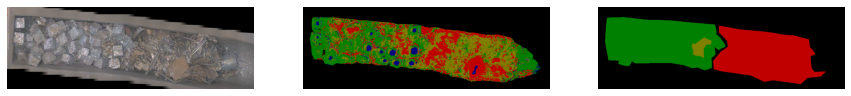

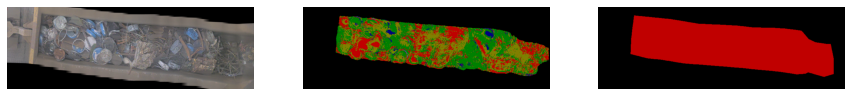

In [22]:
####ACTIVE CELL###########
####Show result in train dataset

num = [0,1,2,3,4,5,6,7]
show_predict_multi(xs,x_train,y_train_raw,num)        

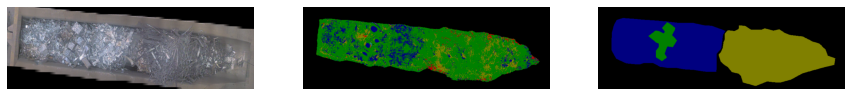

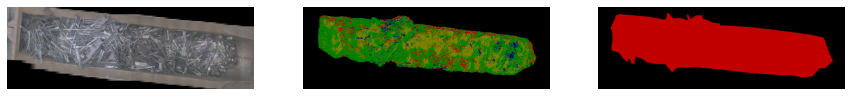

In [23]:
####ACTIVE CELL###########
####Show result in test dataset

num = [10,11]
show_predict_multi(xs_test,x_test,y_test_raw,num)   